# Logistic Regression Final Modeling

In [1]:
# Import libraries
import pandas as pd
import numpy as np

In [2]:
# Import final test dataframe
test = pd.read_csv('/content/drive/MyDrive/data/new_test_final.csv')

In [3]:
# Import final train datafram
train = pd.read_csv('/content/drive/MyDrive/data/new_train_final.csv')

In [4]:
# Define X
X_train = train.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])
X_test = test.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])

In [5]:
y_train = train['rating_category']
y_test = test['rating_category']

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV

# Define the pipeline
logistic_pipeline = Pipeline([
    ('feature_selection', SelectFromModel(LogisticRegression(max_iter=1000))),
    ('classification', LogisticRegression(max_iter=1000))
])

In [21]:
# Define parameter grid
param_grid_logreg = {
    'feature_selection__threshold': [None, "mean"],
    'classification__C': [0.1, 1],
    'classification__solver': ['saga'],
    'classification__penalty': ['l1', 'elasticnet'],
    'classification__l1_ratio': [0.5]
}

In [22]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(logistic_pipeline, param_grid_logreg, cv=5, n_jobs=-1, verbose=2, error_score='raise')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectFromModel(estimator=LogisticRegression(max_iter=1000))),
                                       ('classification',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'classification__C': [0.1, 1],
                         'classification__l1_ratio': [0.5],
                         'classification__penalty': ['l1', 'elasticnet'],
                         'classification__solver': ['saga'],
                         'feature_selection__threshold': [None, 'mean']},
             verbose=2)

In [91]:
import joblib

# Save the trained model
joblib.dump(grid_search.best_estimator_, '/content/drive/MyDrive/data/logreg_model.pkl')

['/content/drive/MyDrive/data/logreg_model.pkl']

In [93]:
from sklearn.preprocessing import label_binarize

# Get class labels from the trained model
class_labels = grid_search.best_estimator_.named_steps['classification'].classes_

# Binarize y_test
y_test_binarized = label_binarize(y_test, classes=class_labels)

# Predict on the test set
y_pred_logreg = grid_search.best_estimator_.predict(X_test)
y_score_logreg = grid_search.best_estimator_.predict_proba(X_test)

In [76]:
# Importing the required libraries
from sklearn.metrics import accuracy_score

# Function for post grid search analysis
def post_grid_search_analysis(grid_search, X_test, y_test):
    # Get the best parameters
    best_params = grid_search.best_params_

    # Predict on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Get the probability scores for the test set (useful for ROC curve, etc.)
    y_score = grid_search.best_estimator_.predict_proba(X_test)

    # Calculate the test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)

    # Get the best score (mean cross-validated score of the best_estimator)
    best_score = grid_search.best_score_

    results = {
        'Best Parameters': best_params,
        'Best Score': best_score,
        'Test Accuracy': test_accuracy
    }

    return results


In [77]:
# Execute the function and store the results
results_logreg = post_grid_search_analysis(grid_search, X_test, y_test)

# Print the results
print(f"Best Log Reg Parameters: {results_logreg['Best Parameters']}")
print(f"Best Log Reg Score: {results_logreg['Best Score']}")
print(f"Log Reg Test Accuracy: {results_logreg['Test Accuracy']}")

Best Log Reg Parameters: {'classification__C': 1, 'classification__l1_ratio': 0.5, 'classification__penalty': 'l1', 'classification__solver': 'saga', 'feature_selection__threshold': None}
Best Log Reg Score: 0.6365957446808511
Log Reg Test Accuracy: 0.6348873755893137


Now we can look at the coefficients from our model.

In [74]:
# Get the logistic regression model from the best_estimator_ attribute
logistic_model = grid_search.best_estimator_.named_steps['classification']

# Get the classes from the logistic regression model
classes = logistic_model.classes_

# Get the coefficients
coefficients = logistic_model.coef_

# Get the feature selection step from the best_estimator_ attribute
feature_selection_model = grid_search.best_estimator_.named_steps['feature_selection']

# Get the mask of kept features
mask = feature_selection_model.get_support()

# Get the names of the features that were kept
feature_names = X_train.columns[mask]

# Create a DataFrame for the coefficients
coef_df = pd.DataFrame(coefficients, columns=feature_names)

# Label the rows with the class names
coef_df['class'] = classes

# Set 'class' as the index
coef_df.set_index('class', inplace=True)

# Sort the DataFrame
sorted_coef = coef_df.T.sort_values(by=classes[0], ascending=False)


In [75]:
sorted_coef.head(20)

class,Average,Excellent,Good,Poor
budget,1.182112,-2.156219,-0.348253,1.304628
unigram_nice,1.166454,-1.237323,0.322850,-0.253378
unigram_lot,1.034401,-0.886278,-0.170082,0.021960
unigram_interesting,0.984818,-1.417371,0.489966,-0.057431
unigram_premise,0.956685,-0.528887,-0.151412,-0.043800
unigram_little,0.954271,-0.665395,0.302496,-0.591493
unigram_isnt,0.934380,-1.431557,-0.360358,0.857536
unigram_gore,0.927737,-0.980052,-0.912535,0.968331
unigram_want,0.904242,-0.902669,0.000000,0.000000
unigram_decent,0.885624,-1.716742,-0.733041,1.564160


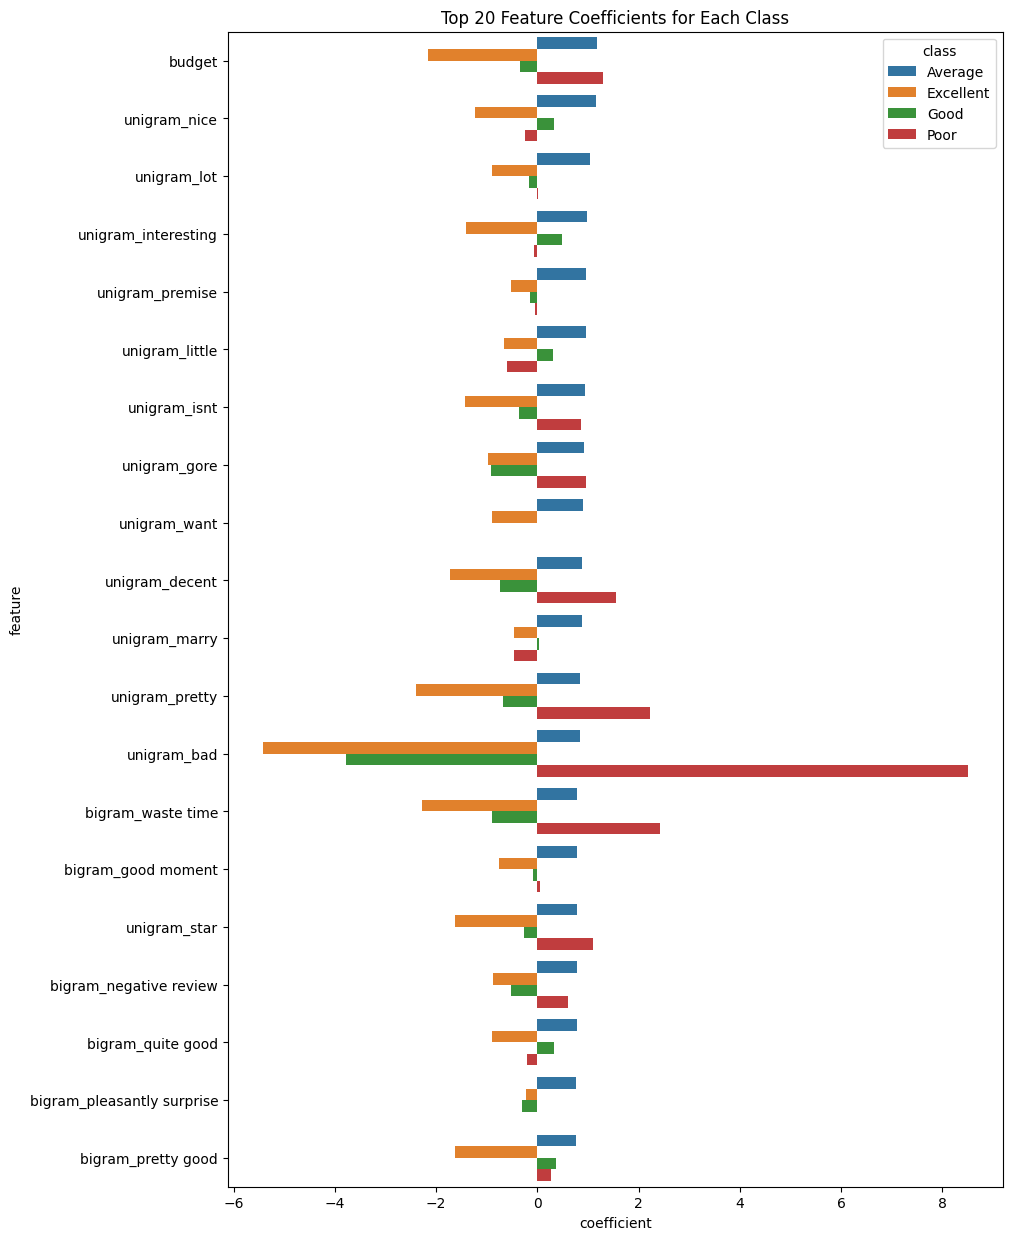

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# let's consider only the first 20 features for better visibility
top_n = 20
sorted_coef_top_n = sorted_coef.head(top_n).reset_index()
sorted_coef_top_n = sorted_coef_top_n.rename(columns={'index': 'feature'})
melted_coef = pd.melt(sorted_coef_top_n, id_vars='feature', var_name='class', value_name='coefficient')

# Plotting
plt.figure(figsize=(10, 15))
sns.barplot(x='coefficient', y='feature', hue='class', data=melted_coef)
plt.title('Top {} Feature Coefficients for Each Class'.format(top_n))
plt.show()


In [79]:
# Getting class labels
class_labels = grid_search.best_estimator_.named_steps['classification'].classes_

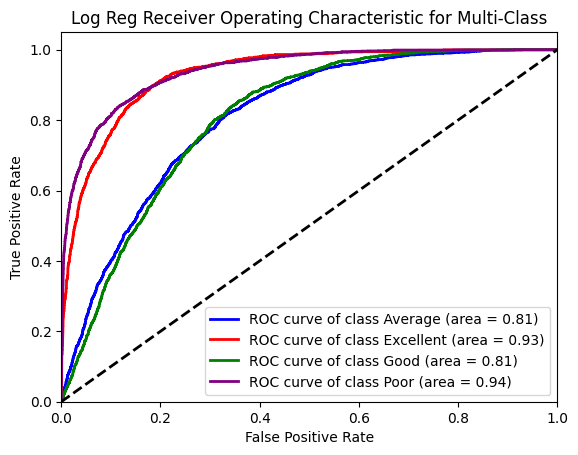

In [94]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Use the y_test_binarized we created earlier
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_logreg[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log Reg Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()


In [86]:
from sklearn.metrics import classification_report

# Generate classification report
logreg_report = classification_report(y_test, y_pred_logreg, target_names=class_labels, output_dict=True)

# Convert the classification report to a dataframe
logreg_report_df = pd.DataFrame(logreg_report).transpose()


In [87]:
logreg_report_df

,precision,recall,f1-score,support
Average,0.533884,0.510269,0.521809,1899.000000
Excellent,0.720023,0.712259,0.716120,1762.000000
Good,0.519864,0.541919,0.530663,1980.000000
Poor,0.770109,0.777444,0.773759,1995.000000
accuracy,0.634887,0.634887,0.634887,0.634887
macro avg,0.635970,0.635473,0.635588,7636.000000
weighted avg,0.634917,0.634887,0.634767,7636.000000


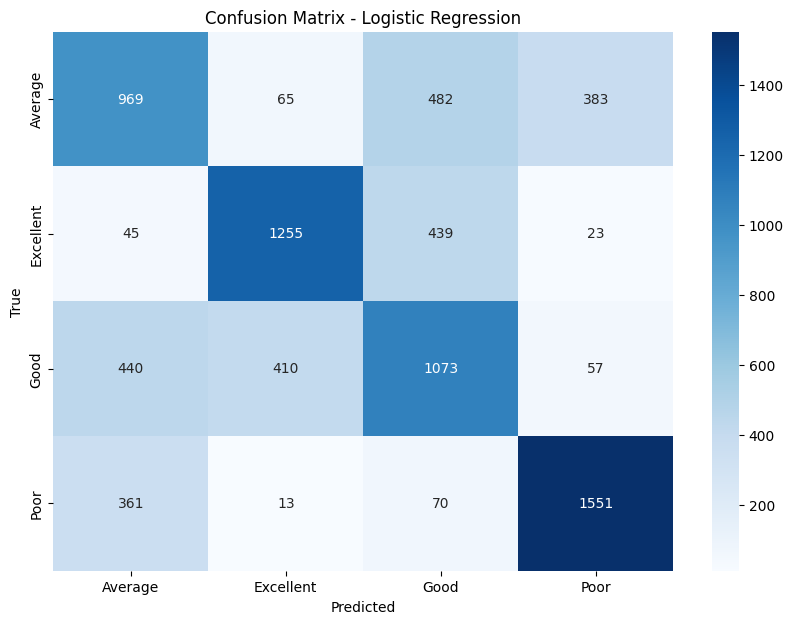

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix for your test and predicted labels
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()